In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('train_2kmZucJ.csv')
train.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


In [3]:
test = pd.read_csv('test_oJQbWVk.csv')
test.head()

,id,tweet
0,7921,I hate the new #iphone upgrade. Won't let me d...
1,7922,currently shitting my fucking pants. #apple #i...
2,7923,"I'd like to puts some CD-ROMS on my iPad, is t..."
3,7924,My ipod is officially dead. I lost all my pict...
4,7925,Been fighting iTunes all night! I only want th...


In [4]:
print("null values train {0}".format(train.isnull().sum()/len(train)))
print("null values test {0}".format(test.isnull().sum()/len(test)))

null values train id       0.0
label    0.0
tweet    0.0
dtype: float64
null values test id       0.0
tweet    0.0
dtype: float64


In [5]:
train['label'].value_counts()/len(train)*100

0    74.419192
1    25.580808
Name: label, dtype: float64

In [6]:
import re
import unidecode
import wordninja

In [7]:
def removepunct(text):
    text = text.lower()
    text = re.sub('@\S+', '', text)
    text = re.sub('http\S+', '', text)
    text = re.sub('pic\S+', '', text)
    text = unidecode.unidecode(text)
    text = re.sub("[^a-zA-Z+']", ' ', text)
    text = re.sub('\s+[a-zA-Z]\s+', ' ', text+' ')
    def preprocess_wordninja(sentence):
        def split_words(x):
            x = wordninja.split(x)
            x = [word for word in x if len(word)>1]
            return x
        new_sentence = [' '.join(split_words(word)) for word in sentence.split()]
        return ' '.join(new_sentence)
    text=preprocess_wordninja(text)
    text = re.sub("\s[\s]+", " ", text).strip()
    return text
    

In [8]:
train['tweet'] = train['tweet'].apply(lambda x:removepunct(x))
train.head()

,id,label,tweet
0,1,0,fingerprint pregnancy test android apps beauti...
1,2,0,finally trans paran silicon case thanks to my ...
2,3,0,we love this would you go talk make memories u...
3,4,0,i'm wired know i'm george was made that way ip...
4,5,1,what amazing service apple won't even talk to ...


In [9]:
test['tweet'] = test['tweet'].apply(lambda x:removepunct(x))
test.head()

,id,tweet
0,7921,hate the new iphone upgrade won't let me downl...
1,7922,currently shitting my fucking pants apple imac...
2,7923,i'd like to puts some cd roms on my ipad is th...
3,7924,my ipod is officially dead lost all my and vid...
4,7925,been fighting itunes all night only want the m...


In [10]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt

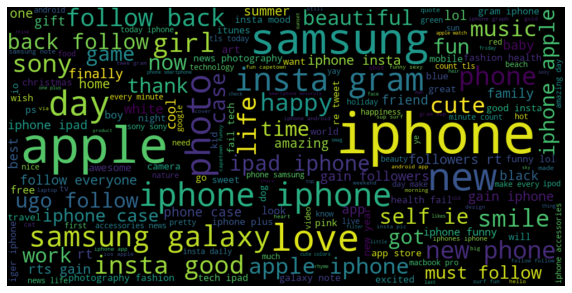

In [11]:
positive = train[train['label']==0]
all_words = ' '.join([x for x in positive['tweet']])
wordcloud = WordCloud(width = 1000, height = 500, random_state=100, max_font_size=100).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

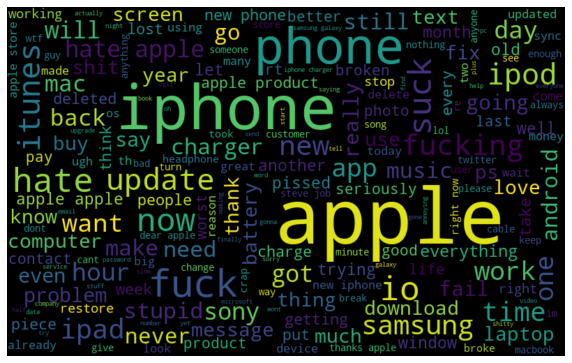

In [12]:
negative = train[train['label']==1]
all_words = ' '.join([text for text in negative['tweet']])
wordcloud = WordCloud(width=800, height=500, random_state=100, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [13]:
import nltk
import spacy

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train['tweet'])

In [15]:
encoded_docs = tokenizer.texts_to_sequences(train['tweet'])

In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding

vocab_size =   25768
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           824576    
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 841,227
Trainable params: 841,227
Non-trainable params: 0
__________________________________________________

In [18]:
history = model.fit(padded_sequence,train['label'],validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
198/198 [==============================] - 27s 129ms/step - loss: 0.4113 - accuracy: 0.8101 - val_loss: 0.2559 - val_accuracy: 0.8920
Epoch 2/5
198/198 [==============================] - 22s 111ms/step - loss: 0.2287 - accuracy: 0.9023 - val_loss: 0.2376 - val_accuracy: 0.8984
Epoch 3/5
198/198 [==============================] - 22s 110ms/step - loss: 0.1884 - accuracy: 0.9276 - val_loss: 0.2435 - val_accuracy: 0.8939
Epoch 4/5
198/198 [==============================] - 23s 116ms/step - loss: 0.1649 - accuracy: 0.9378 - val_loss: 0.2472 - val_accuracy: 0.8895
Epoch 5/5
198/198 [==============================] - 22s 109ms/step - loss: 0.1359 - accuracy: 0.9493 - val_loss: 0.2750 - val_accuracy: 0.8819


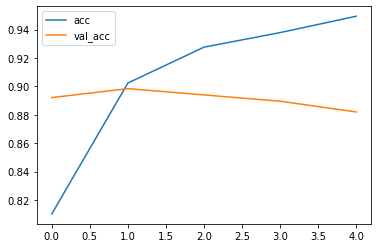

<Figure size 432x288 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

plt.savefig("Accuracy plot.jpg")

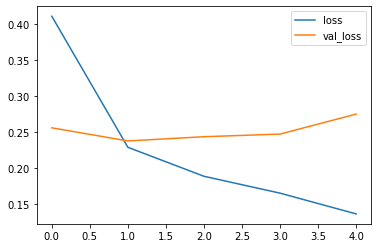

<Figure size 432x288 with 0 Axes>

In [20]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.legend()
plt.show()

plt.savefig("Loss plt.jpg")

In [21]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: ", train['label'][prediction])


test_sentence1 = "I enjoyed my journey on this flight."
predict_sentiment(test_sentence1)

test_sentence2 = "This is the worst flight experience of my life!"
predict_sentiment(test_sentence2)

Predicted label:  0
Predicted label:  0
